# LIBRARY INSTALLATION 

In [ ]:
%%capture
!pip install musdb
!pip install asteroid

!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
!pip install -r requirements.txt
!pip install --editable 

In [ ]:
import speechbrain as sb
from speechbrain.lobes.models.dual_path import SepformerWrapper

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.nn.functional as F
import torchaudio

import musdb
from mir_eval.separation import bss_eval_sources

import librosa
from asteroid.data import MUSDB18Dataset

import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from random import shuffle
from tqdm import tqdm
import csv
import logging
from pathlib import Path

os.environ['MUSDB_PATH'] = '/content'

# TRAINING

## Load Dataset

### Augmentation

In [ ]:
class Compose(object):
    """Composes several augmentation transforms.
    Args:
        augmentations: list of augmentations to compose.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, audio):
        for transform in self.transforms:
            audio = transform(audio)
        return audio


def _augment_gain(audio, low=0.25, high=1.25):
    """Applies a random gain to each source between `low` and `high`"""
    gain = low + torch.rand(1) * (high - low)
    return audio * gain


def _augment_channelswap(audio):
    """Randomly swap channels of stereo sources"""
    if audio.shape[0] == 2 and torch.FloatTensor(1).uniform_() < 0.5:
        return torch.flip(audio, [0])

    return audio

### Training and Validation Dataset object

In [ ]:
root_path = Path('/content/drive/MyDrive/MusDB/wav_8k')

validation_tracks = [
        "Actions - One Minute Smile",
        "Clara Berry And Wooldog - Waltz For My Victims",
        "Johnny Lokke - Promises & Lies",
        "Patrick Talbot - A Reason To Leave",
        "Triviul - Angelsaint",
        "Alexander Ross - Goodbye Bolero",
        "Fergessen - Nos Palpitants",
        "Leaf - Summerghost",
        "Skelpolu - Human Mistakes",
        "Young Griffo - Pennies",
        "ANiMAL - Rockshow",
        "James May - On The Line",
        "Meaxic - Take A Step",
        "Traffic Experiment - Sirens",
    ]

train_list = os.listdir('/content/drive/MyDrive/MusDB/wav_8k/train')
train_subset = [song for song in train_list if song not in validation_tracks]

# Augmentation function
source_augmentations = Compose([globals()["_augment_" + aug] for aug in ['gain', 'channelswap']])

# Load training dataset
train_dataset = MUSDB18Dataset(root_path, 
                               split="train", 
                               subset=train_subset, 
                               sample_rate=8000,
                               source_augmentations=source_augmentations,
                               random_track_mix=True,
                               segment=6,
                               random_segments=True,
                               samples_per_track=64)

# Load validation dataset
valid_dataset = MUSDB18Dataset(root_path, 
                               split="train", 
                               subset=validation_tracks, 
                               sample_rate=8000,
                               segment=80,
                               random_segments=True)

100it [02:46,  1.67s/it]
100it [00:29,  3.36it/s]


In [ ]:
train_dataset[0]

(tensor([[ 0.0562,  0.0386,  0.1169,  ..., -0.0298, -0.0543, -0.0669]]),
 {'bass': tensor([[-0.0257, -0.0099, -0.0275,  ...,  0.0415,  0.0244, -0.0362]]),
  'drums': tensor([[ 0.0807,  0.0624,  0.0333,  ..., -0.0144, -0.0070, -0.0173]]),
  'other': tensor([[ 0.0206,  0.0039,  0.1332,  ..., -0.0688, -0.0831, -0.0255]]),
  'vocals': tensor([[-0.0194, -0.0178, -0.0221,  ...,  0.0120,  0.0113,  0.0122]])})

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 48000])

In [ ]:
train_dataset[0][1]['vocals'].shape

torch.Size([1, 48000])

### Training and validation DataLoader object

In [ ]:
dataloader_kwargs = (
        {"num_workers": 4, "pin_memory": True} if torch.cuda.is_available() else {}
    )

train_sampler = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, **dataloader_kwargs
    )

valid_sampler = torch.utils.data.DataLoader(valid_dataset, batch_size=1, **dataloader_kwargs)

## Training 

### MSS framework class

In [ ]:
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix = mix.to(self.device)

        # Convert targets to tensor
        targets = torch.cat(
            [targets[i].unsqueeze(-1) for i in range(self.hparams.num_spks)],
            dim=-1,
        ).to(self.device)

        print(mix.shape)
        # Separation
        mix_w_1 = self.modules.enc(mix)
        est_mask = self.modules.masker(mix_w_1)
        mix_w = torch.stack([mix_w_1] * self.hparams.num_spks)
        sep_h = mix_w * est_mask

        # Decoding
        est_source = torch.cat(
            [
                self.modules.dec(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = torch.nn.functional.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        true_latents = self.modules.enc(targets.view(self.hparams.num_spks, -1))
        true_latents = true_latents.view(1, 256, -1, self.hparams.num_spks)

        est_mix = self.modules.dec(mix_w_1)

        T_decmix = est_mix.size(1)

        if T_origin > T_decmix:
            est_mix = F.pad(est_mix, (0, T_origin - T_est, 0, 0))
        else:
            est_mix = est_mix[:, :T_origin]

        return est_source, targets, true_latents, est_mix
    
    def compute_objectives(self, predictions, targets):
        """Compute SI-SNR loss"""
        return sb.nnet.losses.get_si_snr_with_pitwrapper(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        mix = batch[0][0]
        bass = batch[1]['bass'][0]
        drums = batch[1]['drums'][0]
        other = batch[1]['other'][0]
        vocals = batch[1]['vocals'][0]

        mix, vocals, bass, drums, other = mix.to(self.device), vocals.to(self.device), bass.to(self.device), drums.to(self.device), other.to(self.device)
        targets = [vocals, bass, drums, other]

        # Perform source separation
        predictions, targets, _, _ = self.compute_forward(mix, targets, sb.Stage.TRAIN)
        # Compute loss
        loss = self.compute_objectives(predictions, targets)

        
        if self.hparams.threshold_byloss:
            # Loss value clipping
            th = -30
            loss_to_keep = loss[loss > th]
            if loss_to_keep.nelement() > 0:
                loss = loss_to_keep.mean()
        else:
            loss = loss.mean()
        
        # Compute and optimize gradient
        if (
            loss < 999999 and loss.nelement() > 0
        ):  # the fix for computational problems
            loss.backward()
            if 5 >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(), 5
                )
            self.optimizer.step()
        else:
            nonfinite_count += 1
            print(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    nonfinite_count
                )
            )
            loss.data = torch.tensor(0).to(self.device)
        
        self.optimizer.zero_grad()
        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        # Unpacking batch list
        mix = batch[0][0]
        bass = batch[1]['bass'][0]
        drums = batch[1]['drums'][0]
        other = batch[1]['other'][0]
        vocals = batch[1]['vocals'][0]
        mix, vocals, bass, drums, other= mix.to(self.device), vocals.to(self.device), bass.to(self.device), drums.to(self.device), other.to(self.device)
        targets = [vocals, bass, drums, other]

        with torch.no_grad():
            # Perform source separation
            predictions, targets, _, _ = self.compute_forward(
                mix, targets, stage)
            # Compute loss
            loss = self.compute_objectives(predictions, targets)

        return loss.detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:

            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, sb.nnet.schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                sb.nnet.schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]
            
            # Train and validation loss logging
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats)

            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]}, min_keys=["si-snr"],
            )

            print('VALID SI-SNR = {}'.format(-stage_loss))
            
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": 1},
                test_stats=stage_stats,
            )

    def reset_layer_recursively(self, layer):
        """Reinitializes the parameters of the neural networks"""
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        for child_layer in layer.modules():
            if layer != child_layer:
                self.reset_layer_recursively(child_layer)



### Model and training hyperparameters

In [ ]:
# Construct the SepFormer blocks
tf_blocks = {'SBtfintra': sb.lobes.models.dual_path.SBTransformerBlock(num_layers=8,
                                                                       d_model=256,
                                                                       nhead=8,
                                                                       d_ffn=1024,
                                                                       dropout=0,
                                                                       use_positional_encoding=True,
                                                                       norm_before=False),
             'SBtfinter': sb.lobes.models.dual_path.SBTransformerBlock(num_layers=8,
                                                                       d_model=256,
                                                                       nhead=8,
                                                                       d_ffn=1024,
                                                                       dropout=0,
                                                                       use_positional_encoding=True,
                                                                       norm_before=False),}

# Construct the whole MSS model
modules = {"enc": sb.lobes.models.dual_path.Encoder(kernel_size=16, out_channels=256),
           "masker": sb.lobes.models.dual_path.Dual_Path_Model(num_spks=4, 
                                                               in_channels=256, 
                                                               out_channels=256,
                                                               num_layers=2,
                                                               K=400,
                                                               intra_model=tf_blocks['SBtfintra'],
                                                               inter_model=tf_blocks['SBtfinter'],
                                                               norm='ln',
                                                               linear_layer_after_inter_intra=True,
                                                               skip_around_intra=True),
           "dec": sb.lobes.models.dual_path.Decoder(in_channels=256,
                                                    out_channels=1,
                                                    kernel_size=16,
                                                    stride=8,
                                                    bias=False)}

# Training hyperparameters
hparams = {'num_spks': 4,
           'lr_scheduler': sb.nnet.schedulers.ReduceLROnPlateau(factor=0.5,
                                                                patience=2,
                                                                dont_halve_until_epoch=1),
           'epoch_counter': sb.utils.epoch_loop.EpochCounter(100),
           'optimizer': lambda x: torch.optim.Adam(x, lr=0.00015),
           'train_logger': sb.utils.train_logger.FileTrainLogger('/content/drive/MyDrive/MusDB/train_log_sepformer_modified1.txt'),
           'reconstruction_loss_weight': 0.05,
           'similarity_loss_weight': 2.0,
           'dissimilarity_loss_weight': 3.0,
           'threshold_byloss': False}

# Training checkpoints
hparams['checkpointer'] = sb.utils.checkpoints.Checkpointer(checkpoints_dir='/content/drive/MyDrive/MusDB/checkpoint_sepformer_modified4',
                                                             recoverables={'encoder': modules['enc'],
                                                                            'decoder': modules['dec'],
                                                                            'masknet': modules['masker'],
                                                                            'counter': hparams['epoch_counter'],
                                                                            'lr_scheduler': hparams['lr_scheduler']})
# Initialize MSS model
brain = Separation(modules, hparams=hparams, opt_class=hparams['optimizer'], run_opts={"device":"cuda:0"}, checkpointer=hparams['checkpointer'])

In [ ]:
# Reinitializes the parameters of the neural networks
for module in brain.modules.values():
    brain.reset_layer_recursively(module)

### Fitting and validation

In [ ]:
brain.fit(hparams['epoch_counter'], train_set=train_sampler, valid_set=valid_sampler)

  0%|          | 0/5504 [00:00<?, ?it/s]

torch.Size([1, 48000])


  0%|          | 1/5504 [00:03<5:25:22,  3.55s/it, train_loss=26.4]

torch.Size([1, 48000])


  0%|          | 2/5504 [00:04<3:16:41,  2.15s/it, train_loss=23]

torch.Size([1, 48000])


  0%|          | 3/5504 [00:05<2:33:02,  1.67s/it, train_loss=19.4]

torch.Size([1, 48000])


  0%|          | 4/5504 [00:06<2:12:28,  1.45s/it, train_loss=19.6]

torch.Size([1, 48000])


  0%|          | 5/5504 [00:08<2:01:11,  1.32s/it, train_loss=20.6]

torch.Size([1, 48000])


  0%|          | 6/5504 [00:09<1:54:27,  1.25s/it, train_loss=22]

torch.Size([1, 48000])


  0%|          | 7/5504 [00:10<1:50:03,  1.20s/it, train_loss=19.8]

torch.Size([1, 48000])


  0%|          | 8/5504 [00:11<1:47:19,  1.17s/it, train_loss=20.4]

torch.Size([1, 48000])


  0%|          | 9/5504 [00:12<1:45:23,  1.15s/it, train_loss=19.5]

torch.Size([1, 48000])


  0%|          | 10/5504 [00:13<1:44:23,  1.14s/it, train_loss=20.1]

torch.Size([1, 48000])


  0%|          | 11/5504 [00:14<1:43:38,  1.13s/it, train_loss=19]

torch.Size([1, 48000])


  0%|          | 12/5504 [00:15<1:43:06,  1.13s/it, train_loss=19.4]

torch.Size([1, 48000])


  0%|          | 13/5504 [00:16<1:42:44,  1.12s/it, train_loss=18.5]

torch.Size([1, 48000])


  0%|          | 14/5504 [00:18<1:42:36,  1.12s/it, train_loss=17.7]

torch.Size([1, 48000])


  0%|          | 15/5504 [00:19<1:42:18,  1.12s/it, train_loss=16.9]

torch.Size([1, 48000])


  0%|          | 15/5504 [00:20<2:06:10,  1.38s/it, train_loss=17.2]


KeyboardInterrupt: ignored

In [ ]:
batch_contoh = next(iter(train_sampler))
batch_contoh[1]['vocals'][0].shape

torch.Size([1, 48000])

# TESTING

In [ ]:
mix_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_6.wav'
drum1_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_0.wav'
drum2_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_1.wav'
drum3_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_2.wav'
other_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_3.wav'
bass_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_4.wav'
vocals_gt_file = '/content/drive/MyDrive/MusDB/Sultans of Swing/chan_5.wav'

mix_gt = librosa.load(mix_gt_file, sr=8000, duration=80)[0]
drum1_gt = librosa.load(drum1_gt_file, sr=8000, duration=80)[0]
drum2_gt = librosa.load(drum2_gt_file, sr=8000, duration=80)[0]
drum3_gt = librosa.load(drum3_gt_file, sr=8000, duration=80)[0]
other_gt = librosa.load(other_gt_file, sr=8000, duration=80)[0]
bass_gt = librosa.load(bass_gt_file, sr=8000, duration=80)[0]
vocals_gt = librosa.load(vocals_gt_file, sr=8000, duration=80)[0]

In [ ]:
from IPython.display import Audio

Audio(mixture, rate=8000)

In [ ]:
mix_t = torch.tensor(mix_gt).unsqueeze(0)
vocals_t = torch.tensor(vocals_gt).unsqueeze(0)
bass_t = torch.tensor(bass_gt).unsqueeze(0)
drums_t = torch.tensor(drum1_gt + drum2_gt + drum3_gt).unsqueeze(0)
other_t = torch.tensor(other_gt).unsqueeze(0)

mixture = vocals_t + bass_t + drums_t + other_t
targets = [vocals_t, bass_t, drums_t, other_t]
with torch.no_grad():
    # Perform source separation on test dataset
    predictions, targets, _, _ = brain.compute_forward(mixture, targets, sb.Stage.TEST)

In [ ]:
predictions.shape

torch.Size([1, 640000, 4])

In [ ]:
predictions_new = torch.stack((predictions[0,:,3],
                              predictions[0,:,1],
                              predictions[0,:,0],
                              predictions[0,:,2]), dim=1).unsqueeze(0)

predictions_new.shape

torch.Size([1, 640000, 4])

In [ ]:
targets_new = torch.stack((vocals_t,
                           bass_t,
                           drums_t,
                           other_t), dim=2)

targets_new.shape

torch.Size([1, 640000, 4])

In [ ]:
Audio(predictions_new[0,:,0].cpu(), rate=8000)

In [ ]:
Audio(targets_new[0,:,0].cpu(), rate=8000)

In [ ]:
sdr, _, _, _ = bss_eval_sources(
                targets_new[0].t().cpu().numpy(),
                predictions_new[0].t().cpu().numpy(),
            )

sdr

array([4.47545751, 3.82706529, 7.70646855, 1.14874383])

In [ ]:
save_path = os.path.join("/content/drive/MyDrive/MusDB/Sultans of Swing", "separations")    # Separated audio signal 
if not os.path.exists(save_path):
    os.mkdir(save_path)

for ns in range(4):
    # Estimated source
    signal = predictions_new[0, :, ns]
    signal = signal / signal.abs().max()
    save_file = os.path.join(
        save_path, "sos_source{}hat.wav".format(ns + 1)
    )
    torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), 8000  # save estimated source audio
    )

    # Original source
    signal = targets_new[0, :, ns]
    signal = signal / signal.abs().max()
    save_file = os.path.join(
        save_path, "sos_source{}.wav".format(ns + 1)
    )
    torchaudio.save(
        save_file, signal.unsqueeze(0).cpu(), 8000  # save original source audio
    )

## Load Dataset dan DataLoader

In [ ]:
s_rate = 8000
dur = 80
test_list = os.listdir('/content/drive/MyDrive/MusDB/wav_8k/test')
root_path = Path('/content/drive/MyDrive/MusDB/wav_8k')

test_dataset = MUSDB18Dataset(root_path, 
                               split="test", 
                               sample_rate=s_rate,
                               segment=dur,
                               random_segments=False)

test_sampler = torch.utils.data.DataLoader(test_dataset, batch_size=1, **dataloader_kwargs)

49it [01:09,  1.42s/it]


In [ ]:
contoh = next(iter(test_sampler))
contoh

[tensor([[[-3.0518e-05,  0.0000e+00, -3.0518e-05,  ..., -1.9836e-02,
           -2.4445e-02, -1.6846e-02]]]),
 {'bass': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            -3.0518e-05, -3.0518e-05]]]),
  'drums': tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -0.0168, -0.0226, -0.0170]]]),
  'other': tensor([[[ 0.0000,  0.0000,  0.0000,  ..., -0.0030, -0.0018,  0.0002]]]),
  'vocals': tensor([[[-3.0518e-05,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]]])}]

In [ ]:
contoh[0].shape

torch.Size([1, 1, 640000])

## Evaluation

In [ ]:
device = torch.device('cuda')
save_file = os.path.join("/content/drive/MyDrive/MusDB", "test_results_newest.csv") # SDR record
save_path = os.path.join("/content/drive/MyDrive/MusDB", "audio_results_newest")    # Separated audio signal 
if not os.path.exists(save_path):
    os.mkdir(save_path)

# Empty list of SDR and SI-SNR values
all_sdrs = []
all_sdrs_vocal = []
all_sdrs_bass = []
all_sdrs_drums = []
all_sdrs_other = []
all_sdrsb_vocal = []
all_sdrsb_bass = []
all_sdrsb_drums = []
all_sdrsb_other = []
all_sdrs_b = []
all_sdrs_i = []
all_sisnrs = []
all_sisnrs_i = []
csv_columns = ["song_id", "sdr_vocal", "sdr_bass", "sdr_drums", "sdr_other",
               "sdr", "sdrb_vocal", "sdrb_bass", "sdrb_drums", "sdrb_other", 
               "sdr_b", "sdr_i", "si-snr",  "si-snr_i"]

with open(save_file, "w") as results_csv:
    # write csv file for recording SDR values
    writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
    writer.writeheader()

    # Loop over all tracks in the test data_loader
    with tqdm(test_sampler, dynamic_ncols=True) as t:
        for i, batch in enumerate(t):

            # Unpacking batch list
            mixture = batch[0][0]
            vocals = batch[1]['vocals'][0]
            bass = batch[1]['bass'][0]
            drums = batch[1]['drums'][0]
            other = batch[1]['other'][0]
            targets = [vocals, bass, drums, other]

            with torch.no_grad():
                # Perform source separation on test dataset
                predictions, targets, _, _ = brain.compute_forward(
                    mixture, targets, sb.Stage.TEST)

            for ns in range(4):
                # Estimated source
                signal = predictions[0, :, ns]
                signal = signal / signal.abs().max()
                save_file = os.path.join(
                    save_path, "item{}_source{}hat.wav".format(i + 1, ns + 1)
                )
                torchaudio.save(
                    save_file, signal.unsqueeze(0).cpu(), 8000  # save estimated source audio
                )

                # Original source
                signal = targets[0, :, ns]
                signal = signal / signal.abs().max()
                save_file = os.path.join(
                    save_path, "item{}_source{}.wav".format(i + 1, ns + 1)
                )
                torchaudio.save(
                    save_file, signal.unsqueeze(0).cpu(), 8000  # save original source audio
                )

            # Mixture
            signal = mixture[0, :]
            signal = signal / signal.abs().max()
            save_file = os.path.join(save_path, "item{}_mix.wav".format(i + 1))
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), 8000      # save mixture audio
            )

            # Compute SI-SNR
            sisnr = brain.compute_objectives(predictions, targets)

            # Compute SI-SNR improvement
            mixture_signal = torch.stack(
                [mixture] * 4, dim=-1)
            mixture_signal = mixture_signal.to(device)
            sisnr_baseline = brain.compute_objectives(
                mixture_signal, targets)
            sisnr_i = sisnr - sisnr_baseline

            # Compute SDR of individual sources
            sdr, _, _, _ = bss_eval_sources(
                targets[0].t().cpu().numpy(),
                predictions[0].t().detach().cpu().numpy(),
            )

            # Compute SDR improvement of individual sources over the original mixture
            sdr_baseline, _, _, _ = bss_eval_sources(
                targets[0].t().cpu().numpy(),
                mixture_signal[0].t().detach().cpu().numpy(),
            )

            sdr_i = sdr.mean() - sdr_baseline.mean()

            # Saving SDR on a csv file
            row = {
                "song_id": i+1,
                "sdr_vocal": sdr[0],
                "sdr_bass": sdr[1],
                "sdr_drums": sdr[2],
                "sdr_other": sdr[3],
                "sdr": sdr.mean(),
                "sdrb_vocal": sdr_baseline[0],
                "sdrb_bass": sdr_baseline[1],
                "sdrb_drums": sdr_baseline[2],
                "sdrb_other": sdr_baseline[3],
                "sdr_b": sdr_baseline.mean(),
                "sdr_i": sdr_i,
                "si-snr": -sisnr.item(),
                "si-snr_i": -sisnr_i.item(),
            }
            writer.writerow(row)

            # Metric Accumulation
            all_sdrs.append(sdr.mean())
            all_sdrs_vocal.append(sdr[0])
            all_sdrs_bass.append(sdr[1])
            all_sdrs_drums.append(sdr[2])
            all_sdrs_other.append(sdr[3])
            all_sdrsb_vocal.append(sdr_baseline[0])
            all_sdrsb_bass.append(sdr_baseline[1])
            all_sdrsb_drums.append(sdr_baseline[2])
            all_sdrsb_other.append(sdr_baseline[3])
            all_sdrs_b.append(sdr_baseline.mean())
            all_sdrs_i.append(sdr_i.mean())
            all_sisnrs.append(-sisnr.item())
            all_sisnrs_i.append(-sisnr_i.item())

        row = {
            "song_id": "avg",
            "sdr_vocal": np.array(all_sdrs_vocal).mean(),
            "sdr_bass": np.array(all_sdrs_bass).mean(),
            "sdr_drums": np.array(all_sdrs_drums).mean(),
            "sdr_other": np.array(all_sdrs_other).mean(),
            "sdr": np.array(all_sdrs).mean(),
            "sdrb_vocal": np.array(all_sdrsb_vocal).mean(),
            "sdrb_bass": np.array(all_sdrsb_bass).mean(),
            "sdrb_drums": np.array(all_sdrsb_drums).mean(),
            "sdrb_other": np.array(all_sdrsb_other).mean(),
            "sdr_b": np.array(all_sdrs_b).mean(),
            "sdr_i": np.array(all_sdrs_i).mean(),
            "si-snr": np.array(all_sisnrs).mean(),
            "si-snr_i": np.array(all_sisnrs_i).mean(),
        }
        writer.writerow(row)


logger = logging.getLogger(__name__)
logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))

100%|██████████| 48/48 [49:29<00:00, 61.87s/it]


# MISCELLANEOUS

## Plot train vs validation loss

In [ ]:
import pandas as pd

#header_sep = ['epoch', 'train_sep', 'val_sep']
df_sep = pd.read_csv('/content/drive/MyDrive/MusDB/train_log_sisnr.txt', delimiter=' ', header=None)
df_sep = df_sep.drop(df_sep.columns[[0, 2, 3, 4, 5, 6, 8, 9, 10]], axis=1)
df_sep = df_sep.replace(',','', regex=True)
df_sep.columns = ['epoch', 'train_sep', 'val_sep']

#header_conv = ['epoch', 'train_conv', 'val_conv']
df_conv = pd.read_csv('/content/drive/MyDrive/MusDB/train_log_convtasnet.txt', delimiter=' ', header=None)
df_conv = df_conv.drop(df_conv.columns[[0, 2, 3, 4, 5, 6, 8, 9, 10]], axis=1)
df_conv = df_conv.replace(',','', regex=True)
df_conv.columns = ['epoch', 'train_conv', 'val_conv']

df_sep['train_conv'] = df_conv['train_conv']
df_sep['val_conv'] = df_conv['val_conv']

df_sep

epoch  train_sep  val_sep  train_conv  val_conv
0       1      10.56    1.950        9.42     3.000
1       2       9.63    2.770        8.61     1.080
2       3       8.45    2.620        7.22     3.620
3       4       7.32    0.976        8.37     0.773
4       5       9.31    2.490        8.45     0.501
..    ...        ...      ...         ...       ...
195   196       5.86   -1.090        3.99    -0.727
196   197       6.48   -1.110        5.26    -0.506
197   198       5.64    1.580        4.97    -2.010
198   199       6.16   -1.090        4.39    -2.170
199   200       5.27    0.187        4.00    -0.696

[200 rows x 5 columns]

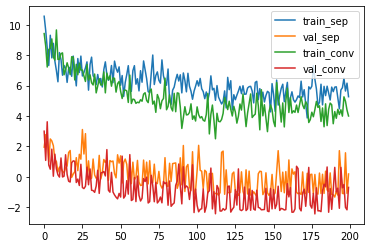

In [ ]:
import matplotlib.pyplot as plt

df_sep.plot()